## Humpback whale classification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *

In [3]:
from fastai.conv_learner import *
from fastai.transforms import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
PATH = 'data/whale/'

In [5]:
ls {PATH}

models/                test/     tmp/    train.csv
sample_submission.csv  test.zip  train/  train.zip


### Exploring the image

In [6]:
def plot_images_for_filenames(filenames, labels, rows=4):
    imgs = [plt.imread(f'{PATH}/train/{filename}') for filename in filenames]
    
    return plot_images(imgs, labels, rows)
    
def plot_images(imgs, labels, rows=4):
    # Set figure to 13 inches x 8 inches
    figure = plt.figure(figsize=(13, 8))

    cols = len(imgs) // rows + 1

    for i in range(len(imgs)):
        subplot = figure.add_subplot(rows, cols, i + 1)
        subplot.axis('Off')
        if labels:
            subplot.set_title(labels[i], fontsize=16)
        plt.imshow(imgs[i])

In [7]:
np.random.seed(24)

## using resnext 50

In [8]:
sz = 224
arch = resnext50
bs = 24

In [9]:
def get_1st(path): return glob(f'{path}/*.*')[0]

In single-label classification each sample belongs to one class. In the previous example, each image is either a *dog* or a *cat*.

In multi-label classification each sample can belong to one or more clases. In the previous example, the first images belongs to two clases: *haze* and *primary*. The second image belongs to four clases: *agriculture*, *clear*, *primary* and  *water*.

## Read labelled data, creating validation set

In [10]:
label_csv = f'{PATH}train.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)
val_idxs = val_idxs[:100]

In [11]:
labels_df = pd.read_csv(label_csv)
labels_df.head()

,Image,Id
0,00022e1a.jpg,w_e15442c
1,000466c4.jpg,w_1287fbc
2,00087b01.jpg,w_da2efe0
3,001296d5.jpg,w_19e5482
4,0014cfdf.jpg,w_f22f3e3


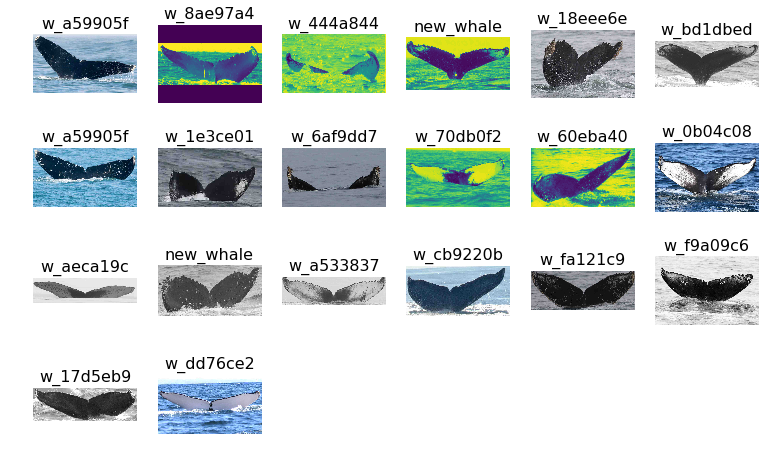

In [12]:
rand_rows = labels_df.sample(frac=1.)[:20]
imgs = list(rand_rows['Image'])
labels = list(rand_rows['Id'])

plot_images_for_filenames(imgs, labels)

We use a different set of data augmentations for this dataset - we also allow vertical flips, since we don't expect vertical orientation of satellite images to change our classifications.

In [13]:
def get_data(sz):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    return ImageClassifierData.from_csv(PATH, 'train', label_csv, test_name='test', tfms=tfms,
                    val_idxs=val_idxs)

In [14]:
data = get_data(224)

In [15]:
x,y = next(iter(data.val_dl))

In [16]:
y


 3201
  614
  890
 2955
 4104
 2620
  527
  431
  241
  173
 2990
    0
  652
 4005
  177
 2669
 2638
 3203
 3942
 2378
 2620
 3010
 2663
  498
  767
 3589
 1203
    0
 3026
 3592
 3476
  544
 3252
 3192
  757
 1329
  301
  956
 1182
 1643
  756
 1680
  294
 2573
  106
   15
  760
 3997
 3320
 2782
  389
 2501
    0
 3673
 2687
 2721
 3481
 2469
 2214
 4219
 1372
 2628
  809
 1724
[torch.LongTensor of size 64]

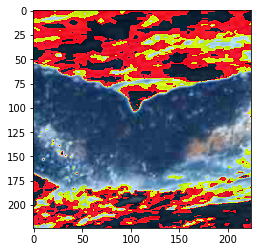

In [17]:
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.4);

In [18]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 86%|████████▌ | 131/153 [00:02<00:00, 46.25it/s, loss=132] 


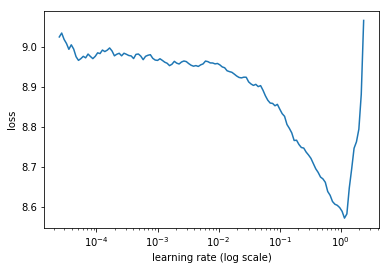

In [19]:
lrf=learn.lr_find()
learn.sched.plot()

In [20]:
learn.fit(1e-2, 5)
learn.precompute=False

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[0.      8.41846 7.91034 0.08681]                           
[1.      7.53795 7.71089 0.08681]                           
[2.      7.00856 7.57325 0.10069]                           
[3.      6.54838 7.49331 0.10851]                           
[4.      6.08575 7.3723  0.11632]                           



In [21]:
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[0.      6.73886 7.34232 0.10851]                           
[1.      6.5868  7.17467 0.10851]                           
[2.      6.30265 7.17084 0.11632]                           
[3.      6.3159  7.13258 0.12413]                           
[4.      6.10811 7.1048  0.13194]                           
[5.      5.85838 7.06237 0.13194]                           
[6.      5.76518 7.05797 0.13194]                           



In [22]:
#lrs = np.array([lr/9,lr/3,lr])

In [23]:
#learn.unfreeze()
#learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

In [24]:
learn.save('humpback_whale')
learn.load('humpback_whale')

In [25]:
test_preds,y = learn.TTA(is_test=True)

In [26]:
preds_avg = np.mean(test_preds, axis=0)

In [27]:
#preds = np.argmax(preds_avg, axis=1)
#probs = np.exp(preds_avg)
probs = np.exp(test_preds)
probs.shape

(15610, 4251)

In [28]:
data.test_ds.fnames

['test/c292553f.jpg',
 'test/c70ca9cc.jpg',
 'test/18ff383f.jpg',
 'test/5802f268.jpg',
 'test/080f5fab.jpg',
 'test/a075c784.jpg',
 'test/ca130a09.jpg',
 'test/a32fc078.jpg',
 'test/3a08fd5e.jpg',
 'test/cd316c62.jpg',
 'test/eb9aa389.jpg',
 'test/59dc6925.jpg',
 'test/4a3dda56.jpg',
 'test/4799d6d7.jpg',
 'test/107fbca3.jpg',
 'test/97efd070.jpg',
 'test/0e987496.jpg',
 'test/85afb6bd.jpg',
 'test/1e2bf374.jpg',
 'test/ea2ca0a2.jpg',
 'test/7a2b8779.jpg',
 'test/4e168c7e.jpg',
 'test/8ebbfbf1.jpg',
 'test/5e2fed01.jpg',
 'test/39e4f5a3.jpg',
 'test/8a16a939.jpg',
 'test/c6d9e63a.jpg',
 'test/1f33c310.jpg',
 'test/961d5312.jpg',
 'test/faa7fad3.jpg',
 'test/397bc85e.jpg',
 'test/7a8de645.jpg',
 'test/bb643a35.jpg',
 'test/b2ed17ce.jpg',
 'test/e080f337.jpg',
 'test/b5a61d42.jpg',
 'test/bdf86b00.jpg',
 'test/88a66661.jpg',
 'test/20d0ffc1.jpg',
 'test/8f047c48.jpg',
 'test/9e912090.jpg',
 'test/944ceaee.jpg',
 'test/0e8e84c2.jpg',
 'test/c0ca04a0.jpg',
 'test/c4362011.jpg',
 'test/0a0

In [29]:
#top5probs = probs.argmax(axis=1)
data.classes

['new_whale',
 'w_0013924',
 'w_001ebbc',
 'w_002222a',
 'w_002b682',
 'w_002dc11',
 'w_0087fdd',
 'w_008c602',
 'w_009dc00',
 'w_00b621b',
 'w_00c4901',
 'w_00cb685',
 'w_00d8453',
 'w_00fbb4e',
 'w_0103030',
 'w_010a1fa',
 'w_011d4b5',
 'w_0122d85',
 'w_01319fa',
 'w_0134192',
 'w_013bbcf',
 'w_014250a',
 'w_014a645',
 'w_0156f27',
 'w_015c991',
 'w_015e3cf',
 'w_01687a8',
 'w_0175a35',
 'w_018bc64',
 'w_01a4234',
 'w_01a51a6',
 'w_01a99a5',
 'w_01ab6dc',
 'w_01b2250',
 'w_01c2cb0',
 'w_01cbcbf',
 'w_01d6ca0',
 'w_01e1223',
 'w_01f211f',
 'w_01f8a43',
 'w_01f9086',
 'w_024358d',
 'w_0245a27',
 'w_0265cb6',
 'w_026fdf8',
 'w_028ca0d',
 'w_029013f',
 'w_02a768d',
 'w_02b775b',
 'w_02bb4cf',
 'w_02c2248',
 'w_02c9470',
 'w_02cf46c',
 'w_02d5fad',
 'w_02d7dc8',
 'w_02e5407',
 'w_02facde',
 'w_02fce90',
 'w_030294d',
 'w_0308405',
 'w_0324b97',
 'w_032d44d',
 'w_0337aa5',
 'w_034a3fd',
 'w_0378699',
 'w_037955e',
 'w_03a2ed7',
 'w_03b5e9a',
 'w_03c6d18',
 'w_03c84ef',
 'w_03dc41c',
 'w_03

In [30]:
#top5probs
#probs[top5probs].shape
ds=pd.DataFrame(probs)
ds.columns = data.classes

In [31]:
ds.insert(0,'id',[out[5:] for out in data.test_ds.fnames])

In [32]:
ds.head()

,id,new_whale,w_0013924,w_001ebbc,w_002222a,w_002b682,w_002dc11,w_0087fdd,w_008c602,w_009dc00,...,w_ff70408,w_ff7630a,w_ff94ad6,w_ffa7427,w_ffa78a5,w_ffb4e3d,w_ffbd74c,w_ffcd98e,w_ffda8b2,w_ffdab7a
0,c292553f,0.022390,0.000110,0.000028,0.000186,0.000382,0.000055,0.000584,0.000089,0.000057,...,0.000120,0.000200,0.000021,0.000160,0.000027,0.000091,0.000125,0.000118,0.000105,0.000096
1,c70ca9cc,0.117190,0.000122,0.000028,0.000306,0.000268,0.000048,0.000045,0.000271,0.000674,...,0.000040,0.000311,0.000113,0.000899,0.000078,0.000211,0.000148,0.000447,0.000045,0.000103
2,18ff383f,0.102055,0.000206,0.000255,0.000112,0.000295,0.000066,0.000098,0.000143,0.000133,...,0.000187,0.000153,0.000184,0.000281,0.000051,0.000133,0.000081,0.000095,0.000026,0.000071
3,5802f268,0.006519,0.000101,0.000097,0.000031,0.000019,0.000507,0.000103,0.000032,0.000007,...,0.000028,0.000205,0.000034,0.000048,0.000207,0.000021,0.000157,0.000121,0.000052,0.000027
4,080f5fab,0.014350,0.000402,0.000331,0.000043,0.000222,0.000056,0.000204,0.000200,0.000020,...,0.000046,0.000162,0.000249,0.000071,0.000201,0.000042,0.000094,0.000123,0.000019,0.000155


In [34]:
ds.to_csv('whale_sub.gz',compression='gzip',index=False)

In [35]:
FileLink('whale_sub.gz')

/home/nathanwang/whale_sub.gz

### End